# Credit Risk Modelling 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)

# 1. Dataset Overview

- Dataset merupakan data pinjaman nasabah dari sebuah Bank tahun 2007 hingga 2014
- Dengan adanya data ini dapat dibuat sebuah model yang dapat menentukan grade resiko pinjaman calon nasabah


In [4]:
df = pd.read_csv('loan_data_2007_2014.csv')

C:\Users\refdinal\AppData\Local\Temp\ipykernel_4688\1028708547.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan_data_2007_2014.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# 2. Data Preprocessing
- Data Terdiri dari 75 Kolom
- Terdapat Fitur-fitur seperti:
  - Status dan Kondisi Pengajuan pinjaman
  - Fitur Demografi dan Pekerjaan
  - Riwayat Kredit dan progress pembayaran
- Target merupakan loan_status yang akan dilabeli dengan 1 jika lancar(Good) dan 0 jika tidak lancar(Bad)
- Model yang digunakan adalah model klasifikasi

## Data Cleansing

- Cek data kolom yang memiliki nilai null > dari 60% dan hapus kolom2 tersebut

In [9]:
# Menghitung persentase nilai null per kolom
null_percentage = df.isnull().mean() * 100

# Memilih kolom dengan persentase null lebih dari 60%
columns_above_60 = null_percentage[null_percentage > 60]

# Menampilkan kolom-kolom yang memiliki lebih dari 60% nilai null
columns_above_60

desc                            72.981975
mths_since_last_record          86.566585
mths_since_last_major_derog     78.773926
annual_inc_joint               100.000000
dti_joint                      100.000000
verification_status_joint      100.000000
open_acc_6m                    100.000000
open_il_6m                     100.000000
open_il_12m                    100.000000
open_il_24m                    100.000000
mths_since_rcnt_il             100.000000
total_bal_il                   100.000000
il_util                        100.000000
open_rv_12m                    100.000000
open_rv_24m                    100.000000
max_bal_bc                     100.000000
all_util                       100.000000
inq_fi                         100.000000
total_cu_tl                    100.000000
inq_last_12m                   100.000000
dtype: float64

In [10]:
columns_above_60df = pd.DataFrame(columns_above_60).reset_index()
columns_above_60df.columns = ["Fitur", "Persentase Missing Value"]

In [11]:
columns_above_60df

,Fitur,Persentase Missing Value
0,desc,72.981975
1,mths_since_last_record,86.566585
2,mths_since_last_major_derog,78.773926
3,annual_inc_joint,100.000000
4,dti_joint,100.000000
5,verification_status_joint,100.000000
6,open_acc_6m,100.000000
7,open_il_6m,100.000000
8,open_il_12m,100.000000
9,open_il_24m,100.000000


In [12]:
# Hapus kolom yang memiliki banyak data null
df = df.drop(columns=columns_above_60.index)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  466285 non-null  int64  
 1   id                          466285 non-null  int64  
 2   member_id                   466285 non-null  int64  
 3   loan_amnt                   466285 non-null  int64  
 4   funded_amnt                 466285 non-null  int64  
 5   funded_amnt_inv             466285 non-null  float64
 6   term                        466285 non-null  object 
 7   int_rate                    466285 non-null  float64
 8   installment                 466285 non-null  float64
 9   grade                       466285 non-null  object 
 10  sub_grade                   466285 non-null  object 
 11  emp_title                   438697 non-null  object 
 12  emp_length                  445277 non-null  object 
 13  home_ownership

- Cek dan remove kolom yang sekiranya tidak relevan untuk modelling
  - Unnamed: 0 : uniq value pada database
  - id : uniq value pada database
  - member_id : uniq id pelanggan
  - issue_d : tanggal penerbitan pinjaman
  - url : url link detail pinjaman
  - title : judul pengajuan pinjaman
  - zip_code : kode pos
  - earliest_cr_line : tanggal kredit pertama peminjam

In [15]:
# remove kolom yang tidak relevan
col_to_remove = ['Unnamed: 0', 'id', 'member_id','issue_d','url','title','zip_code','earliest_cr_line']
# Hapus kolom 
df = df.drop(columns=col_to_remove)

- beberapa fitur dapat diremove yaitu fitur yang hanya ada setelah pinjaman disetujui
  - funded_amnt : Jumlah pinjaman yang didanai akan ada setelah pinjaman dilakukan
  - funded_amnt_inv : Jumlah pinjaman yang didanai oleh investor akan ada setelah pinjaman dilakukan
  - initial_list_status : pendanaan oleh investor/ beberapa investor yang akan ada setelah pinjaman disetujui
  - out_prncp : fitur yang relevan setelah pinjaman
  - out_prncp_inv : fitur yang relevan setelah pinjaman
  - total_pymt : fitur saat pinjaman berlangsung
  - total_pymnt_inv
  - total_rec_prncp
  - total_rec_int
  - total_rec_late_fee
  - recoveries
  - collection_recovery_fee
  - last_pymnt_d
  - last_pymnt_amnt
  - next_pymnt_d
  - last_credit_pull_d
  - policy_code : hanya 1 uniq
  - application_type : hanya 1 uniq
  - tot_coll_amt : banyak nilai null
  - tot_cur_bal
  - total_rev_hi_lim

In [17]:
# remove kolom yang tidak relevan dengan target
col_to_remove2 = ['funded_amnt','funded_amnt_inv',
                'initial_list_status','out_prncp','out_prncp_inv','total_pymnt',
                'total_pymnt_inv','total_rec_prncp','total_rec_prncp','total_rec_int',
                'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d',
                'policy_code','application_type','tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
# Hapus kolom 
df = df.drop(columns=col_to_remove2)

In [18]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,466285.0,NaN,NaN,NaN,14317.277577,8286.509164,500.0,8000.0,12000.0,20000.0,35000.0
term,466285,2,36 months,337953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,466285.0,NaN,NaN,NaN,13.829236,4.357587,5.42,10.99,13.66,16.49,26.06
installment,466285.0,NaN,NaN,NaN,432.061201,243.48555,15.67,256.69,379.89,566.58,1409.99
grade,466285,7,B,136929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,466285,35,B3,31686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,438697,205475,Teacher,5399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,445277,11,10+ years,150049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,466285,6,MORTGAGE,235875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,466281.0,NaN,NaN,NaN,73277.38147,54963.568654,1896.0,45000.0,63000.0,88960.0,7500000.0


- Terdapat beberapa fitur dan bebarapa target yang tidak akan digunakan
  - Fitur grade dapat dihilangkan dan digunakan sub_grade
  - emp_title : terlalu banyak uniq
  - title : juga terlalu banyak uniq
  - addr_state : terlalu banyak uniq

In [20]:
# remove fitur yang lebih baik tidak digunakan
col_to_remove3 = ['grade','emp_title','addr_state']
# Hapus kolom 
df = df.drop(columns=col_to_remove3)

In [21]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,466285.0,NaN,NaN,NaN,14317.277577,8286.509164,500.0,8000.0,12000.0,20000.0,35000.0
term,466285,2,36 months,337953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,466285.0,NaN,NaN,NaN,13.829236,4.357587,5.42,10.99,13.66,16.49,26.06
installment,466285.0,NaN,NaN,NaN,432.061201,243.48555,15.67,256.69,379.89,566.58,1409.99
sub_grade,466285,35,B3,31686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,445277,11,10+ years,150049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,466285,6,MORTGAGE,235875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,466281.0,NaN,NaN,NaN,73277.38147,54963.568654,1896.0,45000.0,63000.0,88960.0,7500000.0
verification_status,466285,3,Verified,168055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_status,466285,9,Current,224226,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  int64  
 1   term                        466285 non-null  object 
 2   int_rate                    466285 non-null  float64
 3   installment                 466285 non-null  float64
 4   sub_grade                   466285 non-null  object 
 5   emp_length                  445277 non-null  object 
 6   home_ownership              466285 non-null  object 
 7   annual_inc                  466281 non-null  float64
 8   verification_status         466285 non-null  object 
 9   loan_status                 466285 non-null  object 
 10  pymnt_plan                  466285 non-null  object 
 11  purpose                     466285 non-null  object 
 12  dti                         466285 non-null  float64
 13  delinq_2yrs   

## Fill missing Value
- emp_length akan diisi dengan 0 yang merupakan lama bekerja
- mth_since_last_delinq merupakan Jumlah bulan sejak keterlambatan pembayaran terakhir (delinquency).

In [24]:
null_counts = df.isnull().sum()
null_counts

loan_amnt                          0
term                               0
int_rate                           0
installment                        0
sub_grade                          0
emp_length                     21008
home_ownership                     0
annual_inc                         4
verification_status                0
loan_status                        0
pymnt_plan                         0
purpose                            0
dti                                0
delinq_2yrs                       29
inq_last_6mths                    29
mths_since_last_delinq        250351
open_acc                          29
pub_rec                           29
revol_bal                          0
revol_util                       340
total_acc                         29
collections_12_mths_ex_med       145
acc_now_delinq                    29
dtype: int64

In [25]:
null_countsdf = pd.DataFrame(null_counts).reset_index()
null_countsdf.columns = ["Fitur", "Missing Values Counts"]

In [26]:
null_countsdf.sort_values(by="Missing Values Counts", ascending=False)

,Fitur,Missing Values Counts
15,mths_since_last_delinq,250351
5,emp_length,21008
19,revol_util,340
21,collections_12_mths_ex_med,145
22,acc_now_delinq,29
13,delinq_2yrs,29
20,total_acc,29
17,pub_rec,29
16,open_acc,29
14,inq_last_6mths,29


In [27]:
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(0).astype(int)
df['emp_length'] = df['emp_length'].fillna('< 1 year')


### Remove Null Data

In [29]:
# Jumlah baris yang mengandung nilai null pada setiap kolom
null_counts = df.isnull().sum()
print("Jumlah baris null per kolom:")
print(null_counts)
# drop null
df = df.dropna()

Jumlah baris null per kolom:
loan_amnt                       0
term                            0
int_rate                        0
installment                     0
sub_grade                       0
emp_length                      0
home_ownership                  0
annual_inc                      4
verification_status             0
loan_status                     0
pymnt_plan                      0
purpose                         0
dti                             0
delinq_2yrs                    29
inq_last_6mths                 29
mths_since_last_delinq          0
open_acc                       29
pub_rec                        29
revol_bal                       0
revol_util                    340
total_acc                      29
collections_12_mths_ex_med    145
acc_now_delinq                 29
dtype: int64


### Remove Duplicated Data

In [31]:
# Jumlah baris yang merupakan duplikat (termasuk pertama kali)
duplicated_rows = df.duplicated().sum()
print("\nJumlah baris yang duplikat:", duplicated_rows)
# drop duplicated
df = df.drop_duplicates()


Jumlah baris yang duplikat: 0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 465832 entries, 0 to 466284
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   465832 non-null  int64  
 1   term                        465832 non-null  object 
 2   int_rate                    465832 non-null  float64
 3   installment                 465832 non-null  float64
 4   sub_grade                   465832 non-null  object 
 5   emp_length                  465832 non-null  object 
 6   home_ownership              465832 non-null  object 
 7   annual_inc                  465832 non-null  float64
 8   verification_status         465832 non-null  object 
 9   loan_status                 465832 non-null  object 
 10  pymnt_plan                  465832 non-null  object 
 11  purpose                     465832 non-null  object 
 12  dti                         465832 non-null  float64
 13  delinq_2yrs        

In [33]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
loan_amnt,465832.0,NaN,NaN,NaN,14321.609346,8284.854321,500.0,8000.0,12000.0,20000.0,35000.0
term,465832,2,36 months,337580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,465832.0,NaN,NaN,NaN,13.82887,4.357579,5.42,10.99,13.66,16.49,26.06
installment,465832.0,NaN,NaN,NaN,432.186127,243.433199,15.67,256.88,380.17,566.74,1409.99
sub_grade,465832,35,B3,31667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,465832,11,10+ years,149943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,465832,6,MORTGAGE,235666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,465832.0,NaN,NaN,NaN,73268.716892,54938.3178,1896.0,45000.0,63000.0,88842.0,7500000.0
verification_status,465832,3,Verified,167934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_status,465832,9,Current,224120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot Data Numerical

In [35]:
num = ['loan_amnt', 'int_rate','installment','annual_inc', 'dti', 'delinq_2yrs', 
    'inq_last_6mths','mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc','collections_12_mths_ex_med', 'acc_now_delinq']

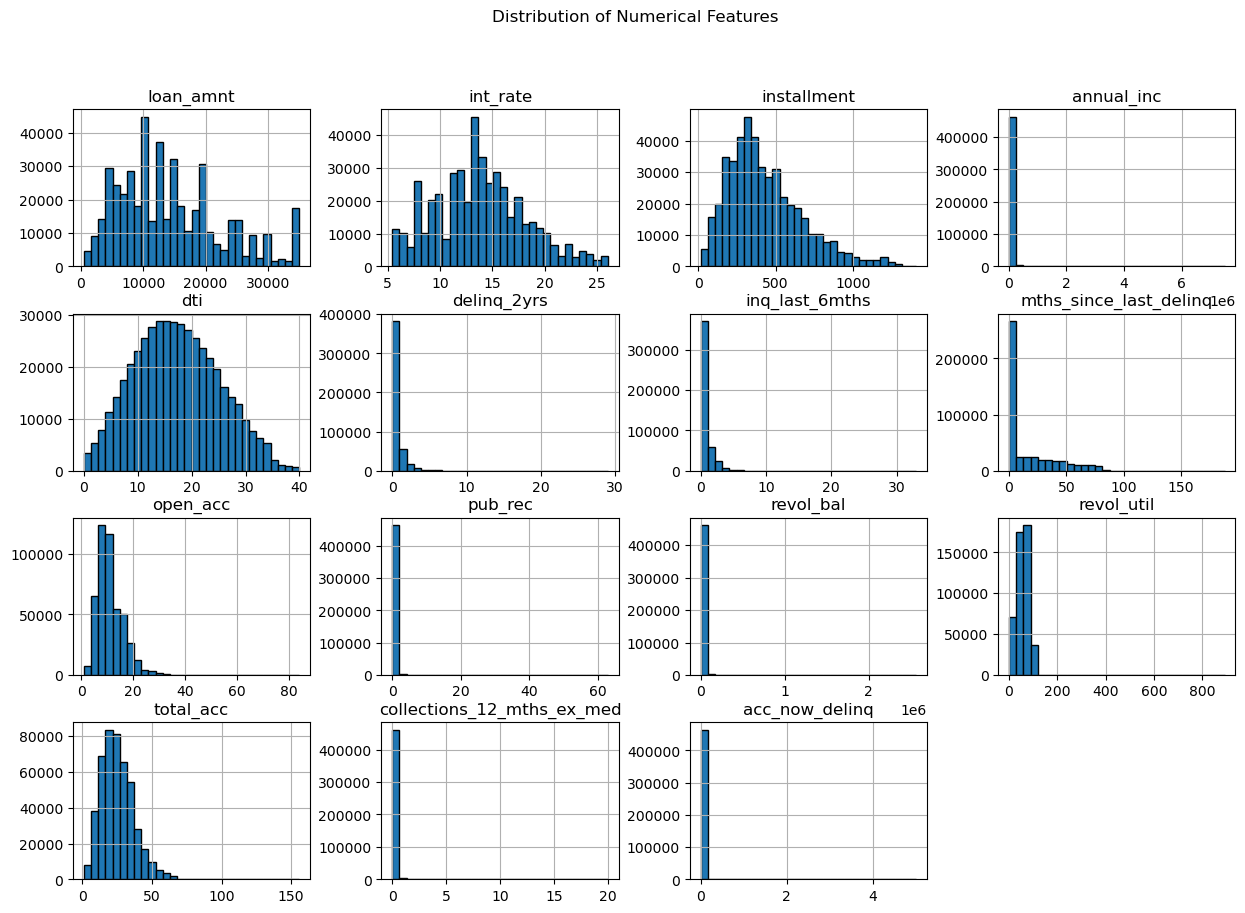

In [36]:
# numerical plot
import matplotlib.pyplot as plt

# Plot histogram untuk fitur numerik
df[num].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()


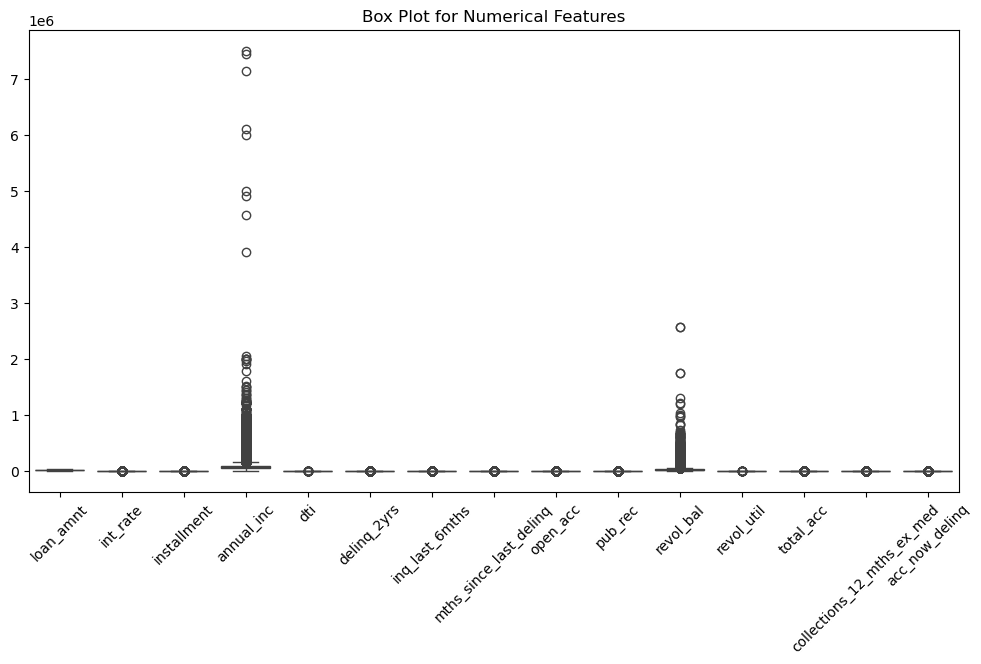

In [37]:
# Box plot untuk fitur numerik
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[num])
plt.title('Box Plot for Numerical Features')
plt.xticks(rotation=45)
plt.show()


- meskipun banyak outlier dan data tidak berdistribusi normal , outlier tidak akan dihandle untuk sekarang
- akan digunakan scaler dan model yang robust terhadap outlier

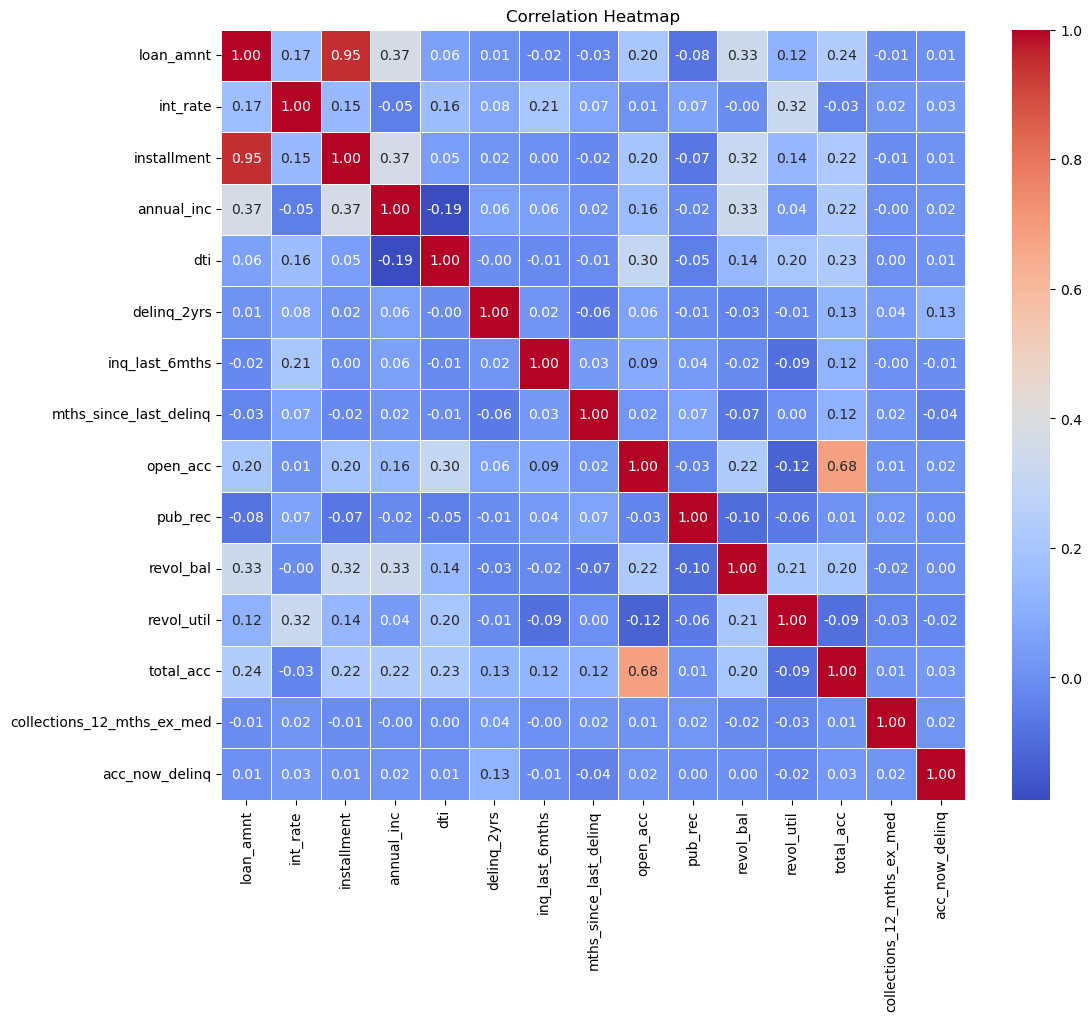

In [39]:
# Korelasi antar variabel numerik
correlation_matrix = df[num].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



- terdapat fitur dengan korelasi tinggi yaitu loan_amnt dan installment
- tetapi kedua fitur ini dirasa memiliki makna yang cukup berpengaruh terhadap keputusan pinjaman nasabah
- sehingga akan tetap menggunakan fitur ini dan memilih model yang tahan terhadap multikolinearitas

## Plot Data categorical

In [42]:
cat = ['sub_grade','term', 'emp_length','home_ownership','verification_status', 'pymnt_plan', 'purpose']

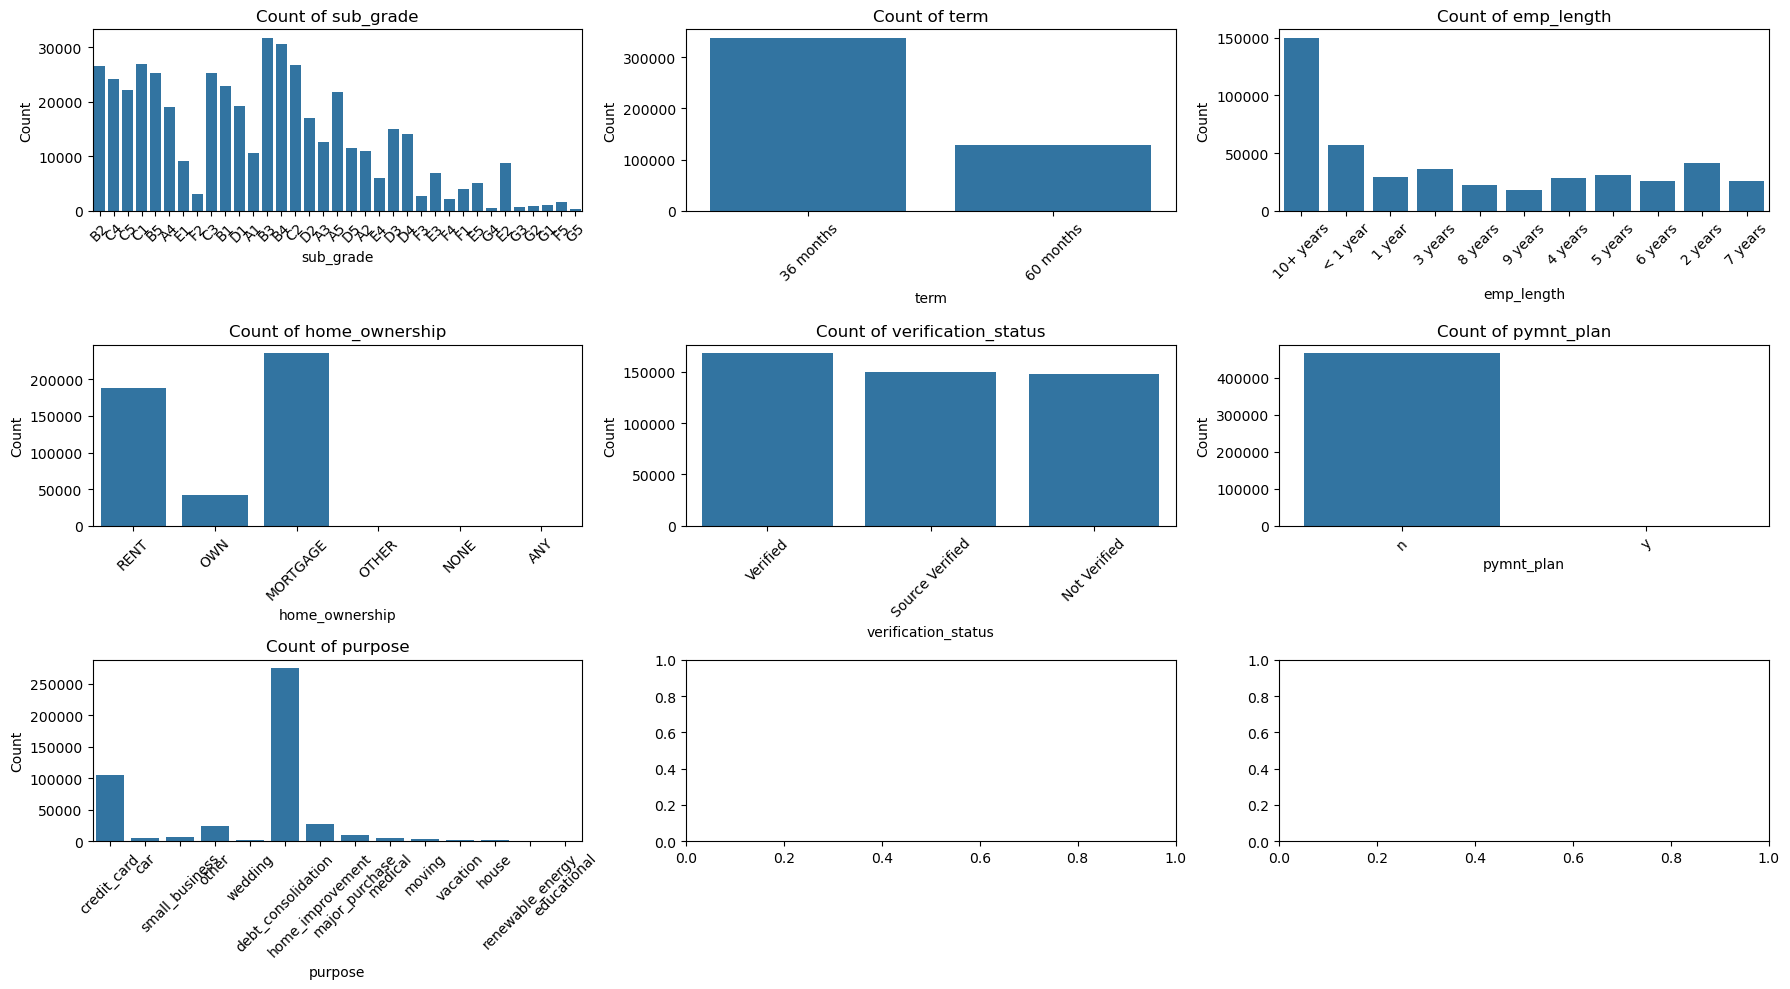

In [43]:
# Set up the figure and axes (2 rows, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(18, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each categorical column
for i, col in enumerate(cat):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

- Fitur sub_grade akan dikonversi dengan label encoding
- Fitur term akan dikonversi menjadi numerik 36 dan 60
- Fitur emp_length akan dikonversi dengan label encoding
- Fitur home_ownership akan dilakukan one-hot encoding dengan menjadikan 4 kategori saja
- Fitur verification_status akan dikonversi dengan label encoding
- Fitur payment plant akan dikonversi dengan label encoding
- Fitur purpose akan dilakukan one-hot encoding

In [45]:
# Data Sub-Grade
sub_grades = [
    "A1", "A2", "A3", "A4", "A5",
    "B1", "B2", "B3", "B4", "B5",
    "C1", "C2", "C3", "C4", "C5",
    "D1", "D2", "D3", "D4", "D5",
    "E1", "E2", "E3", "E4", "E5",
    "F1", "F2", "F3", "F4", "F5",
    "G1", "G2", "G3", "G4", "G5"
]

# Buat Label Encoding: A1 = 35 (paling baik) → G5 = 1 (paling buruk)
sub_grade_labels = {grade: i for i, grade in enumerate(reversed(sub_grades), start=1)}
df['sub_grade'] = df['sub_grade'].map(sub_grade_labels)

In [46]:
# Fitur term akan dikonversi menjadi numerik 36 dan 60
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))
df['term'] = df['term'].astype(int)

In [47]:
# Fitur emp_length akan dikonversi dengan label encoding
emp_length_mapping = {
    '0' : 0,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

# Menerapkan pemetaan ke kolom 'emp_length'
df['emp_length'] = df['emp_length'].map(emp_length_mapping)

In [48]:
df['emp_length'].value_counts()

emp_length
10    149943
0      57172
2      41333
3      36564
5      30753
1      29570
4      27996
7      26157
6      26091
8      22379
9      17874
Name: count, dtype: int64

In [49]:
# Fitur home_ownership akan dilakukan one-hot encoding dengan menjadikan 4 kategori saja
home_ownership_mapping = {
    'OTHER': 'OTHER',
    'NONE': 'OTHER',
    'ANY': 'OTHER'
}

# Mengganti nilai yang sesuai dengan pemetaan
df['home_ownership'] = df['home_ownership'].replace(home_ownership_mapping)

# Melakukan One-Hot Encoding dan langsung menggabungkan ke df, dengan drop_first=True
df = pd.get_dummies(df, columns=['home_ownership'], prefix=['home_ownership'], drop_first=True)

In [50]:
# Fitur verification_status akan dikonversi dengan label encoding
verification_status_mapping = {
    'Verified': 0,
    'Not Verified': 1,
    'Source Verified': 2
}

# Mengubah kolom 'verification_status' menjadi angka menggunakan pemetaan
df['verification_status'] = df['verification_status'].map(verification_status_mapping)


In [51]:
# Fitur payment plant akan dikonversi dengan label encoding
pymnt_plan_mapping = {
    'n': 0,  # 'n' menjadi 0
    'y': 1   # 'y' menjadi 1
}

# Mengubah kolom 'pymnt_plan' menjadi angka menggunakan pemetaan
df['pymnt_plan'] = df['pymnt_plan'].map(pymnt_plan_mapping)

In [52]:
# Fitur purpose akan dilakukan one-hot encoding
df = pd.get_dummies(df, columns=['purpose'], drop_first=True)

In [53]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'annual_inc', 'verification_status', 'loan_status',
       'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [54]:
feature = ['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'annual_inc', 'verification_status',
       'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding']

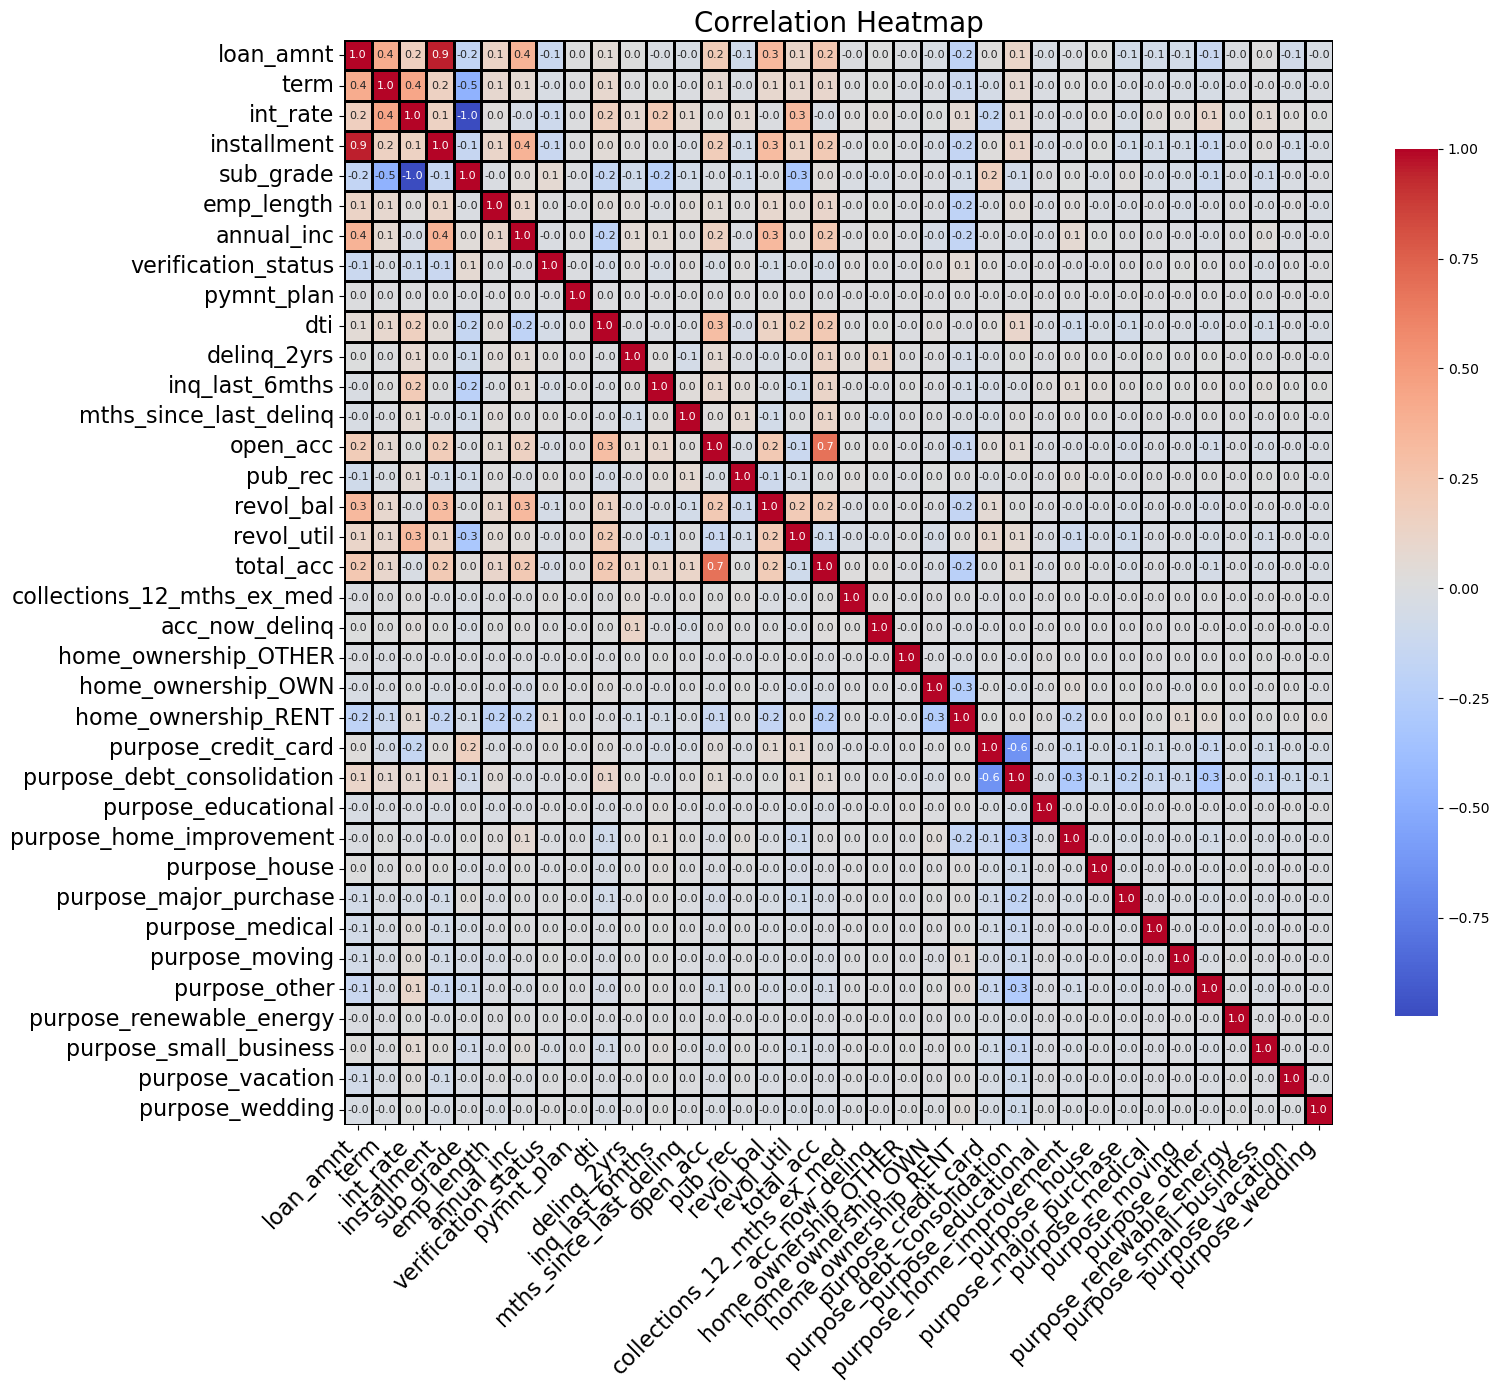

In [55]:
# Korelasi
correlation_ = df[feature].corr()

# Meningkatkan ukuran figure lebih besar
plt.figure(figsize=(16, 14))

# Membuat heatmap dengan pengaturan lebih lanjut
sns.heatmap(correlation_, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.8, linecolor='black', 
            annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=16)  # Menyesuaikan ukuran font sumbu X
plt.yticks(rotation=0, fontsize=16)  # Menyesuaikan ukuran font sumbu Y
plt.tight_layout()  # Mengatur layout agar lebih pas
plt.show()

## Target Encode

In [57]:
df['loan_status'].value_counts()

loan_status
Current                                                224120
Fully Paid                                             184550
Charged Off                                             42422
Late (31-120 days)                                       6895
In Grace Period                                          3144
Does not meet the credit policy. Status:Fully Paid       1914
Late (16-30 days)                                        1217
Default                                                   832
Does not meet the credit policy. Status:Charged Off       738
Name: count, dtype: int64

- Terdapat 8 kategori dan akan diberi label 0 unutk Good loan dan 1 untuk bad loan

In [59]:
df['loan_status'] = df['loan_status'].map({
    'Current': 0,
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
})


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 465832 entries, 0 to 466284
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   465832 non-null  int64  
 1   term                        465832 non-null  int32  
 2   int_rate                    465832 non-null  float64
 3   installment                 465832 non-null  float64
 4   sub_grade                   465832 non-null  int64  
 5   emp_length                  465832 non-null  int64  
 6   annual_inc                  465832 non-null  float64
 7   verification_status         465832 non-null  int64  
 8   loan_status                 465832 non-null  int64  
 9   pymnt_plan                  465832 non-null  int64  
 10  dti                         465832 non-null  float64
 11  delinq_2yrs                 465832 non-null  float64
 12  inq_last_6mths              465832 non-null  float64
 13  mths_since_last_del

## Data Rearrange

In [62]:
df = df[['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'annual_inc', 'verification_status',
       'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'loan_status']]

In [63]:
df.head().T

,0,1,2,3,4
loan_amnt,5000,2500,2400,10000,3000
term,36,60,36,36,60
int_rate,10.65,15.27,15.96,13.49,12.69
installment,162.87,59.83,84.33,339.31,67.79
sub_grade,29,22,21,25,26
emp_length,10,0,10,10,1
annual_inc,24000.0,30000.0,12252.0,49200.0,80000.0
verification_status,0,2,1,2,2
pymnt_plan,0,0,0,0,0
dti,27.65,1.0,8.72,20.0,17.94


In [64]:
# simpan data preprocessing
df.to_csv('processed_data.csv', index=False)


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 465832 entries, 0 to 466284
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   465832 non-null  int64  
 1   term                        465832 non-null  int32  
 2   int_rate                    465832 non-null  float64
 3   installment                 465832 non-null  float64
 4   sub_grade                   465832 non-null  int64  
 5   emp_length                  465832 non-null  int64  
 6   annual_inc                  465832 non-null  float64
 7   verification_status         465832 non-null  int64  
 8   pymnt_plan                  465832 non-null  int64  
 9   dti                         465832 non-null  float64
 10  delinq_2yrs                 465832 non-null  float64
 11  inq_last_6mths              465832 non-null  float64
 12  mths_since_last_delinq      465832 non-null  int32  
 13  open_acc           